# Analyze OME-Zarr for illumination bias
Notebook to process OME-Zarr files generated by Fractal to measure illumination biases

If measurements were made per FOV (using the FOV_ROI_table), this notebook should just run. Otherwise, use a modulo calculation witht he image size to mape back the coordinates to coordinates in a FOV (if imaged in a grid)

path needs to be the path to a AnnData table in a given well

In [25]:
# pip install anndata
# pip install zarr
# pip install seaborn

In [70]:
import anndata as ad
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [128]:
#path = "/Users/joel/shares/workShareJoel/v1_fractal/fractal-demos/examples-v1/07_Cardio_2x2_IlluminationCorrection/tmp_with_illum_corr_v1/output/20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr/B/03/0/tables/nuclei_C01"
path = "/Users/joel/shares/workShareJoel/v1_fractal/fractal-demos/examples-v1/07_Cardio_2x2_IlluminationCorrection/tmp_no_illum_corr_v1/output/20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr/B/03/0/tables/nuclei_C01"
path = "/Users/joel/shares/workShareJoel/v1_fractal/fractal-demos/examples-v1/07_Cardio_2x2_IlluminationCorrection/tmp_no_illum_corr_fullWell_FOV-v2_cellpose_highres/output/20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr/B/03/0/tables/nuclei_C01"
adata = ad.read_zarr(path)
df = adata.to_df()

/Users/joel/mambaforge/envs/fractal-metadata/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Manually create histogram measurements

In [160]:
def calculate_mean_per_bin(df, feature = 'mean_intensity', nb_bins = 20, img_dims_x = 2560, img_dims_y = 2160):
    df_average_intensity = pd.DataFrame()

    start_y = 0
    for y in range(nb_bins):
        start_x = 0
        for x in range(nb_bins):
            window_x = int(img_dims_x / nb_bins)
            window_y = int(img_dims_y / nb_bins)
            mean_value = df[(df['centroid-2'] > start_x) & 
               (df['centroid-2'] < start_x + window_x) & 
               (df['centroid-1'] > start_y) & 
               (df['centroid-1'] < start_y + window_y)][feature].mean()
            new_entry = pd.DataFrame([[start_x + window_x/2, -(start_y + window_y/2), mean_value]], columns = ['X_center', 'Y_center', f'Mean_{feature}'])
            df_average_intensity = pd.concat([df_average_intensity, new_entry])
            start_x += window_x
        start_y += window_y

    return df_average_intensity

def plot_illum_corr(df_average_intensity):
    std_bins = df_average_intensity['Mean_mean_intensity'].std()

    ax = sns.scatterplot(
        data=df_average_intensity, 
        x='X_center', 
        y='Y_center', 
        hue='Mean_mean_intensity', 
        palette="viridis",
        s=150,
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    _ = ax.figure.suptitle(f"Standard Deviation: {std_bins:.2f}")

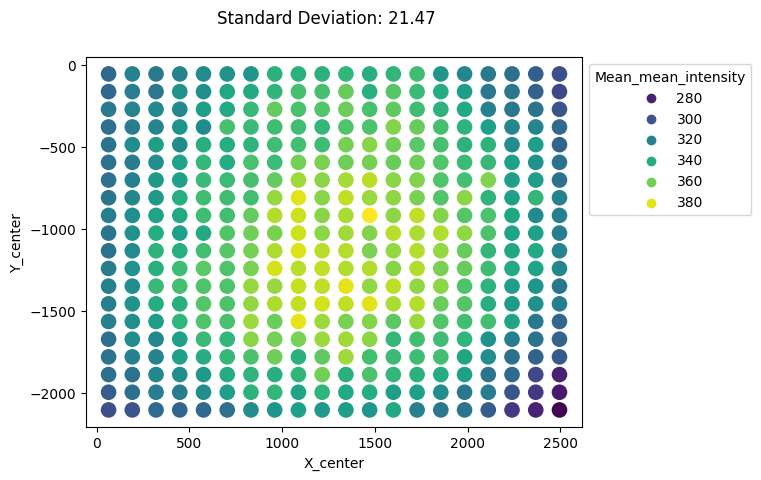

In [159]:
feature = 'mean_intensity'
df_average_intensity = calculate_mean_per_bin(df, feature)
plot_illum_corr(df_average_intensity)

In [162]:
path = "/Users/joel/shares/workShareJoel/v1_fractal/fractal-demos/examples-v1/07_Cardio_2x2_IlluminationCorrection/tmp_with_illum_corr_fullWell_FOV-v2_cellpose_highres/output/20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr/B/03/0/tables/nuclei_C01"
adata = ad.read_zarr(path)
df = adata.to_df()

/Users/joel/mambaforge/envs/fractal-metadata/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,area,bbox_area,convex_area,equivalent_diameter,max_intensity,mean_intensity,min_intensity,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,weighted_centroid-0,weighted_centroid-1,weighted_centroid-2,standard_deviation_intensity
0,2151.0,2580.0,0.0,16.015749,476.0,281.039978,89.0,0.0,26.362158,18.250582,0.0,0.0,0.0,1.0,60.0,43.0,0.0,25.725903,17.841238,52.933598
1,356.0,486.0,0.0,8.793271,695.0,402.654480,118.0,0.0,8.278090,59.022472,0.0,0.0,47.0,1.0,18.0,74.0,0.0,8.274143,59.276390,101.500961
2,1370.0,1664.0,0.0,13.779728,386.0,215.632111,57.0,0.0,13.724088,169.446716,0.0,0.0,142.0,1.0,32.0,194.0,0.0,13.069702,169.076431,49.111111
3,2578.0,3536.0,0.0,17.012238,497.0,255.569046,72.0,0.0,22.034523,283.439087,0.0,0.0,246.0,1.0,52.0,314.0,0.0,21.971706,283.227386,53.122311
4,4087.0,5402.0,0.0,19.836666,466.0,226.965500,34.0,0.0,32.397114,375.494995,0.0,0.0,339.0,1.0,73.0,413.0,0.0,32.471390,375.794434,54.158447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39068,3408.0,4389.0,0.0,18.670975,325.0,194.324829,60.0,0.0,2135.065430,1586.802246,0.0,2103.0,1546.0,1.0,2160.0,1623.0,0.0,2135.065186,1587.216797,38.064079
39069,3068.0,3922.0,0.0,18.028194,452.0,269.549530,34.0,0.0,2137.739258,2215.626221,0.0,2107.0,2180.0,1.0,2160.0,2254.0,0.0,2138.509521,2214.838135,55.150700
39070,2718.0,3525.0,0.0,17.314779,699.0,323.637970,80.0,0.0,2139.871338,2385.863037,0.0,2113.0,2351.0,1.0,2160.0,2426.0,0.0,2140.867676,2387.028320,67.588348
39071,1620.0,2236.0,0.0,14.571541,530.0,286.768524,75.0,0.0,2148.901123,1977.907349,0.0,2134.0,1936.0,1.0,2160.0,2022.0,0.0,2149.385986,1975.908691,69.886070


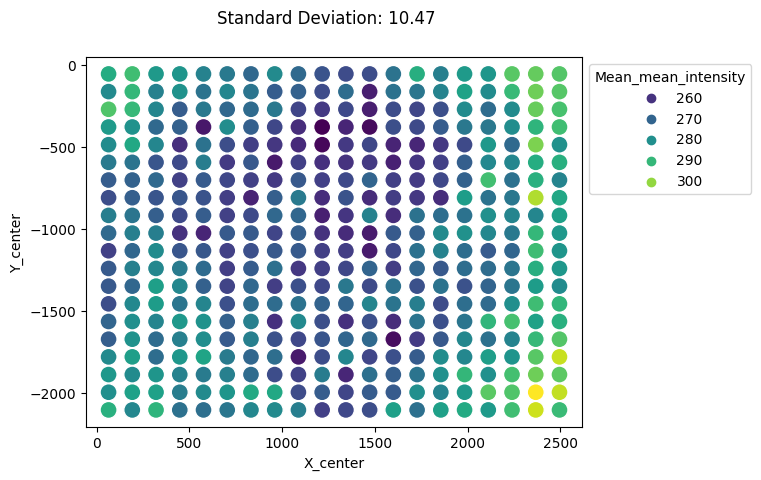

In [ ]:
feature = 'mean_intensity'
df_average_intensity = calculate_mean_per_bin(df, feature)
plot_illum_corr(df_average_intensity)